# Q-learning
Q-learning is a model-free form of machine learning, in the sense that the AI "agent" does not need to know or have a model of the environment that it will be in. The same algorithm can be used across a variety of environments.

Source: https://pythonprogramming.net/q-learning-algorithm-reinforcement-learning-python-tutorial/?completed=/q-learning-reinforcement-learning-python-tutorial/

In [1]:
import gym
import numpy as np

In [2]:
env = gym.make("MountainCar-v0")

# Print the possible no. of actions.
print(env.action_space.n)

3


C:\Users\shaik\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# Sample move
# env.reset()

# done = False
# while not done:
#     action = 2
#     env.step(action)
#     env.render()

In [4]:
state = env.reset()
done = False
while not done:
    action = 2
    new_state, reward, done, _ = env.step(action)
    print(reward, new_state)

-1.0 [-0.58402514  0.0014615 ]
-1.0 [-0.581113    0.00291222]
-1.0 [-0.5767715   0.00434144]
-1.0 [-0.571033    0.00573854]
-1.0 [-0.56393987  0.0070931 ]
-1.0 [-0.555545    0.00839492]
-1.0 [-0.54591084  0.00963415]
-1.0 [-0.53510946  0.01080136]
-1.0 [-0.5232218   0.01188768]
-1.0 [-0.51033694  0.01288485]
-1.0 [-0.4965515   0.01378541]
-1.0 [-0.48196873  0.01458278]
-1.0 [-0.46669737  0.01527137]
-1.0 [-0.45085067  0.01584668]
-1.0 [-0.4345453   0.01630539]
-1.0 [-0.4178999  0.0166454]
-1.0 [-0.40103403  0.01686588]
-1.0 [-0.3840668   0.01696722]
-1.0 [-0.36711577  0.01695102]
-1.0 [-0.35029575  0.01682003]
-1.0 [-0.3337177   0.01657803]
-1.0 [-0.317488   0.0162297]
-1.0 [-0.3017075   0.01578051]
-1.0 [-0.28647098  0.01523654]
-1.0 [-0.27186665  0.01460433]
-1.0 [-0.25797588  0.01389075]
-1.0 [-0.24487306  0.01310282]
-1.0 [-0.23262545  0.01224761]
-1.0 [-0.22129337  0.01133209]
-1.0 [-0.2109303   0.01036307]
-1.0 [-0.20158318  0.00934712]
-1.0 [-0.19329268  0.00829051]
-1.0 [-0.186

The variables in the state are $[\text{x-coordinate}, \text{velocity}]$

## What's a Q-table?
There is a "Q" value per action possible per state. This creates a table. In order to figure out all of the possible states, we can either query the environment (if it is kind enough to us to tell us)...or we just simply have to engage in the environment for a while to figure it out. 

In our case, we can query the enviornment to find out the possible ranges for each of these state values:

In [5]:
print(env.observation_space.high)
print(env.observation_space.low)

[0.6  0.07]
[-1.2  -0.07]


 Can you imagine the size of a Q Table if we were going to have a value for every combination of these ranges out to 8 decimal places? That'd be huge! And, more importantly, it'd be useless. We don't need that much granularity. So, instead, what we want to do is conver these continuous values to discrete values. Basically, we want to bucket/group the ranges into something more manageable.
 
 We'll use 20 groups/buckets for each range

In [6]:
DISCRETE_OS_SIZE = [20, 20]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

# how large each bucket is, basically how much to increment the 
# range by for each bucket
print(discrete_os_win_size)

[0.09  0.007]


In [7]:
# 20 x 20 x 3 matrix
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

We will consult with this table to determine our moves. That final $\times 3$ is our 3 actions and each of those 3 actions have the "Q value" associated with them. When we're being "greedy" and trying to "exploit" our environment, we will choose to go with the action that has the highest Q value for this state. Sometimes, however, especially initially, we may instead wish to "explore" and just choose a random action. These random actions are how our model will learn better moves over time. So how do we learn over time? We need to update these Q values!

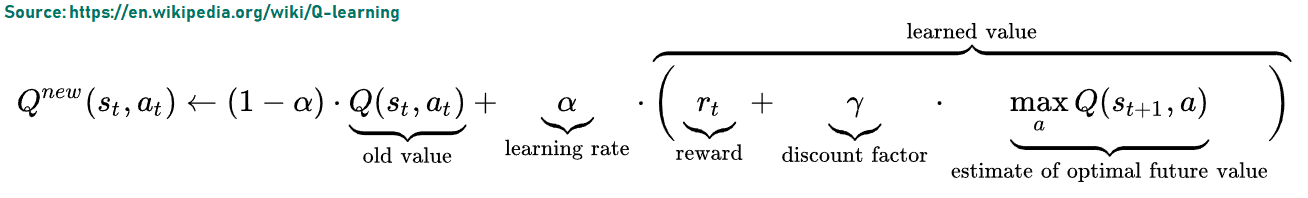

The DISCOUNT is a measure of how much we want to care about FUTURE reward rather than immediate reward. Typically, this value will be fairly high, and is between 0 and 1. We want it high because the purpose of Q Learning is indeed to learn a chain of events that ends with a positive outcome, so it's only natural that we put greater importance on long terms gains rather than short term ones.

In [12]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
# No. of iterations of the game
EPISODES = 4000

In [9]:
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) / discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

As an Agent learns an environment, it moves from "exploration" to "exploitation." Right now, our model is greedy and exploiting for max Q values always...but these Q values are worthless right now. We need the agent to explore!

In [10]:
epsilon = 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [17]:
# For stats
ep_rewards = []
aggr_ep_rewards = {'ep' : [], 'avg' : [], 'max' : [], 'min' : []}
STATS_EVERY = 100

Use a conditional expression with epsilon to choose whether to "exploit" or "explore".

In [22]:
SHOW_EVERY = 1000
for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = get_discrete_state(env.reset())
    done = False
    
    if episode % SHOW_EVERY == 0:
        print(episode)
        
    while not done:
        if np.random.random() > epsilon:
            # Get action from Q table -> exploit
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action -> explore
            action = np.random.randint(0, env.action_space.n)
            
        new_state, reward, done, _  = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)
        
        if episode % SHOW_EVERY == 0:
            # env.render()
            pass

        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state
    
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
        
    ep_rewards.append(episode_reward)
    if episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:]) / STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
    
    if episode % 10 == 0:
        np.save(f"qtables/{episode}-qtable.npy", q_table)

env.close()

C:\Users\shaik\AppData\Local\Temp\ipykernel_468\1367070879.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


0
1000
2000
3000


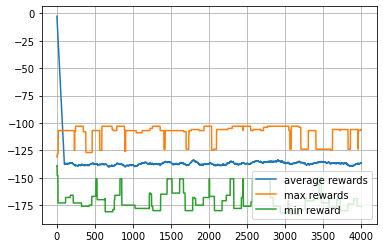

In [21]:
import matplotlib.pyplot as plt

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label='average rewards')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label='max rewards')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label='min reward')
plt.legend(loc=4)
plt.grid()
plt.show()

In [23]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

style.use('ggplot')

In [ ]:
def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    
    return "red", 0.3

## Make a video for the illustration of the Q-table

In [ ]:
fig = plt.figure(figsize=(12, 9))

for i in range(0, EPISODES // 40, 10):
    print(i)
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    q_table = np.load(f"qtables/{i}-qtable.npy")

    for x, x_vals in enumerate(q_table):
        for y, y_vals in enumerate(x_vals):
            ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker='o', alpha=get_q_color(y_vals[0], y_vals)[1])
            ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker='o', alpha=get_q_color(y_vals[1], y_vals)[1])
            ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker='o', alpha=get_q_color(y_vals[2], y_vals)[1])

            ax1.set_ylabel("Action 0")
            ax2.set_ylabel("Action 1")
            ax3.set_ylabel("Action 2")
    
    plt.savefig(f"qtable_charts/{i}.png")
    plt.clf()

In [ ]:
import cv2
import os

def make_video():
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('qlearn.avi', fourcc, 60.0, (1200, 900))
    
    for i in range(0, EPISODES, 10):
        img_path = f"qtable_charts/{i}.png"
        print(img_path)
        frame = cv2.imread(img_path)
        out.write(frame)
        
    out.release()
    
make_video()